# 1. Data Loading

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import SparkSession
import pyspark.ml as ml

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
spark = SparkSession.builder.appName("YourAppName").getOrCreate()

In [3]:
def load_dfs():
    global movies, users, ratings
    movies = spark.read.csv("./Data/movieLens/movies.dat", sep="::", encoding="latin1")
    movies = movies.toDF("movie_id", "movie_name", "genre").cache()
    movies.createOrReplaceTempView("movies_info")
    
    users = spark.read.csv("./Data/movieLens/users.dat", sep="::", encoding="latin1")
    users = users.toDF("user_id", "gender", "age", "occupation", "zipcode").cache()
    users.createOrReplaceTempView("users_info")
    
    ratings = spark.read.csv("./Data/movieLens/ratings.dat", sep="::", encoding="latin1")
    ratings = ratings.toDF("user_id", "movie_id", "rating", "time_stamp").cache()
    ratings.createOrReplaceTempView("ratings_info")

In [4]:
load_dfs()

In [5]:
movies.show(5)

+--------+--------------------+--------------------+
|movie_id|          movie_name|               genre|
+--------+--------------------+--------------------+
|       1|    Toy Story (1995)|Animation|Childre...|
|       2|      Jumanji (1995)|Adventure|Childre...|
|       3|Grumpier Old Men ...|      Comedy|Romance|
|       4|Waiting to Exhale...|        Comedy|Drama|
|       5|Father of the Bri...|              Comedy|
+--------+--------------------+--------------------+
only showing top 5 rows



In [6]:
users.show(5)

+-------+------+---+----------+-------+
|user_id|gender|age|occupation|zipcode|
+-------+------+---+----------+-------+
|      1|     F|  1|        10|  48067|
|      2|     M| 56|        16|  70072|
|      3|     M| 25|        15|  55117|
|      4|     M| 45|         7|  02460|
|      5|     M| 25|        20|  55455|
+-------+------+---+----------+-------+
only showing top 5 rows



In [7]:
ratings.show(5)

+-------+--------+------+----------+
|user_id|movie_id|rating|time_stamp|
+-------+--------+------+----------+
|      1|    1193|     5| 978300760|
|      1|     661|     3| 978302109|
|      1|     914|     3| 978301968|
|      1|    3408|     4| 978300275|
|      1|    2355|     5| 978824291|
+-------+--------+------+----------+
only showing top 5 rows



# 2. Checking Null Values

In [8]:
def inspect_null(df):
    for col in df.columns:
        empty = df.filter(df[col].isNull()).count()
        print(f"For columns {col}:\t{empty} null records")

In [9]:
inspect_null(movies)

For columns movie_id:	0 null records
For columns movie_name:	0 null records
For columns genre:	0 null records


In [10]:
inspect_null(users)

For columns user_id:	0 null records
For columns gender:	0 null records
For columns age:	0 null records
For columns occupation:	0 null records
For columns zipcode:	0 null records


In [11]:
inspect_null(ratings)

For columns user_id:	0 null records
For columns movie_id:	0 null records
For columns rating:	0 null records
For columns time_stamp:	0 null records


# 3. Parsing Movies Attributes

## 3.1. Parsing Movies Names

In [12]:
import re

def extract_date(record):
    pattern  = r'\((\d{4})\)'
    if re.findall(pattern, record.strip()[-6:]):
        return int(record.strip()[-5:-1])
    return None

def extract_name(record):
    pattern  = r'\((\d{4})\)'
    if re.findall(pattern, record.strip()[-6:]):
        return record.strip()[:-6].strip()
    return record

In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, IntegerType

# Define UDFs for extract_date and extract_name functions
extract_date_udf = udf(lambda record: extract_date(record), IntegerType())
extract_name_udf = udf(lambda record: extract_name(record), StringType())

movies = movies.withColumn("year", extract_date_udf(movies["movie_name"]))
movies = movies.withColumn("name", extract_name_udf(movies["movie_name"]))

In [14]:
movies.show(5)

+--------+--------------------+--------------------+----+--------------------+
|movie_id|          movie_name|               genre|year|                name|
+--------+--------------------+--------------------+----+--------------------+
|       1|    Toy Story (1995)|Animation|Childre...|1995|           Toy Story|
|       2|      Jumanji (1995)|Adventure|Childre...|1995|             Jumanji|
|       3|Grumpier Old Men ...|      Comedy|Romance|1995|    Grumpier Old Men|
|       4|Waiting to Exhale...|        Comedy|Drama|1995|   Waiting to Exhale|
|       5|Father of the Bri...|              Comedy|1995|Father of the Bri...|
+--------+--------------------+--------------------+----+--------------------+
only showing top 5 rows



## 3.2. Parsing Movies Genres

In [15]:
movies.select("genre").first()[0].split("|")

['Animation', "Children's", 'Comedy']

In [16]:
from pyspark.sql.functions import col, split, explode

movies = movies.withColumn("genre", explode(split(col("genre"), "\|")))

In [17]:
movies.show()

+--------+--------------------+----------+----+--------------------+
|movie_id|          movie_name|     genre|year|                name|
+--------+--------------------+----------+----+--------------------+
|       1|    Toy Story (1995)| Animation|1995|           Toy Story|
|       1|    Toy Story (1995)|Children's|1995|           Toy Story|
|       1|    Toy Story (1995)|    Comedy|1995|           Toy Story|
|       2|      Jumanji (1995)| Adventure|1995|             Jumanji|
|       2|      Jumanji (1995)|Children's|1995|             Jumanji|
|       2|      Jumanji (1995)|   Fantasy|1995|             Jumanji|
|       3|Grumpier Old Men ...|    Comedy|1995|    Grumpier Old Men|
|       3|Grumpier Old Men ...|   Romance|1995|    Grumpier Old Men|
|       4|Waiting to Exhale...|    Comedy|1995|   Waiting to Exhale|
|       4|Waiting to Exhale...|     Drama|1995|   Waiting to Exhale|
|       5|Father of the Bri...|    Comedy|1995|Father of the Bri...|
|       6|         Heat (1995)|   

In [18]:
movies = movies.drop("movie_name")

In [19]:
movies.show()

+--------+----------+----+--------------------+
|movie_id|     genre|year|                name|
+--------+----------+----+--------------------+
|       1| Animation|1995|           Toy Story|
|       1|Children's|1995|           Toy Story|
|       1|    Comedy|1995|           Toy Story|
|       2| Adventure|1995|             Jumanji|
|       2|Children's|1995|             Jumanji|
|       2|   Fantasy|1995|             Jumanji|
|       3|    Comedy|1995|    Grumpier Old Men|
|       3|   Romance|1995|    Grumpier Old Men|
|       4|    Comedy|1995|   Waiting to Exhale|
|       4|     Drama|1995|   Waiting to Exhale|
|       5|    Comedy|1995|Father of the Bri...|
|       6|    Action|1995|                Heat|
|       6|     Crime|1995|                Heat|
|       6|  Thriller|1995|                Heat|
|       7|    Comedy|1995|             Sabrina|
|       7|   Romance|1995|             Sabrina|
|       8| Adventure|1995|        Tom and Huck|
|       8|Children's|1995|        Tom an

# 4. Data Exploration

## 4.1 Movie Dataset

In [20]:
movies.createOrReplaceTempView("movies_info")

In [21]:
spark.sql("SELECT genre FROM movies_info GROUP BY genre").show()

+-----------+
|      genre|
+-----------+
|      Crime|
|    Romance|
|   Thriller|
|  Adventure|
| Children's|
|      Drama|
|        War|
|Documentary|
|    Fantasy|
|    Mystery|
|    Musical|
|  Animation|
|  Film-Noir|
|     Horror|
|    Western|
|     Comedy|
|     Action|
|     Sci-Fi|
+-----------+



In [22]:
spark.sql("SELECT min(year), max(year) FROM movies_info").show()

+---------+---------+
|min(year)|max(year)|
+---------+---------+
|     1919|     2000|
+---------+---------+



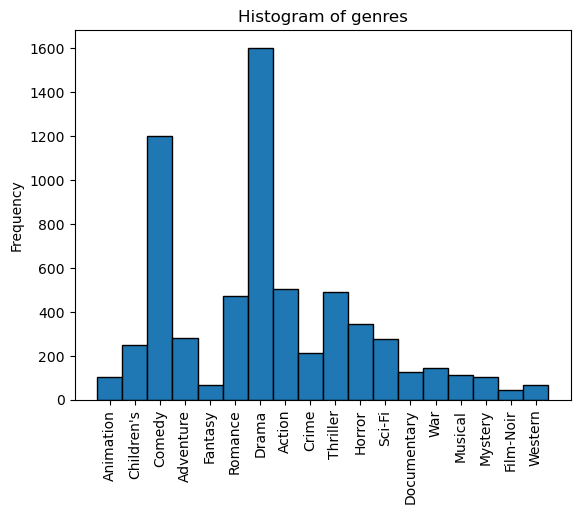

In [23]:
import matplotlib.pyplot as plt

data = spark.sql("SELECT genre FROM movies_info").toPandas()
labels = data["genre"].unique()
counts, bins, _ = plt.hist(data["genre"], edgecolor='black', bins=len(labels))
bin_width = bins[1] - bins[0]
new_ticks = bins[:-1] + bin_width / 2

plt.ylabel('Frequency')
plt.title('Histogram of genres')
plt.xticks(new_ticks, rotation=90)
plt.show()

In [24]:
data = spark.sql("SELECT mean(year) YEAR FROM movies_info GROUP BY movie_id").toPandas()["YEAR"]

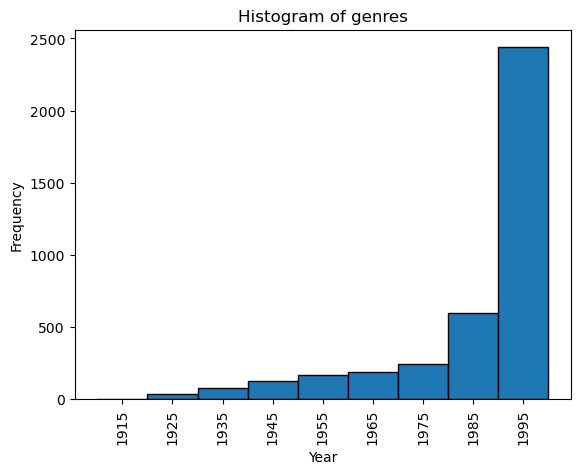

In [25]:
labels = data.unique()
division = 10
counts, bins, _ = plt.hist(data, edgecolor='black', bins=np.arange(np.floor(min(data) / division) * division, 
                                                                   np.ceil(max(data) / division) * division + division, 
                                                                   division))
bin_width = bins[1] - bins[0]
new_ticks = bins[:-1] + bin_width / 2

plt.ylabel('Frequency')
plt.xlabel('Year')
plt.title('Histogram of genres')
plt.xticks(new_ticks, rotation=90)
plt.show()

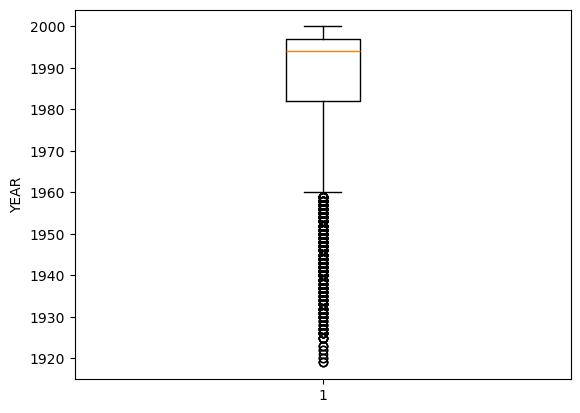

In [26]:
plt.boxplot(data)
plt.ylabel("YEAR")
plt.show()

inspect the correlation between the genre and the ratings

In [27]:
query = """
           SELECT  A.genre, A.rating, A.movie_rating_count, B.total_movies
           FROM    (SELECT genre, rating, COUNT(DISTINCT(movies_info.movie_id)) AS movie_rating_count
                   FROM movies_info
                   INNER JOIN ratings_info ON movies_info.movie_id = ratings_info.movie_id
                   GROUP BY genre, rating) A LEFT JOIN
                   (SELECT genre, COUNT(DISTINCT(movie_id)) AS total_movies
                   FROM movies_info
                   GROUP BY genre) B
                   ON A.genre = B.genre
           ORDER BY rating DESC
        """

data = spark.sql(query)
data.show()

+-----------+------+------------------+------------+
|      genre|rating|movie_rating_count|total_movies|
+-----------+------+------------------+------------+
|    Musical|     5|               107|         114|
|    Mystery|     5|                98|         106|
|    Romance|     5|               421|         471|
|     Action|     5|               446|         503|
|Documentary|     5|                94|         127|
|      Drama|     5|              1309|        1603|
|     Horror|     5|               280|         343|
|        War|     5|               135|         143|
|     Comedy|     5|              1027|        1200|
|    Fantasy|     5|                66|          68|
|  Film-Noir|     5|                40|          44|
| Children's|     5|               232|         251|
|   Thriller|     5|               442|         492|
|  Animation|     5|               103|         105|
|  Adventure|     5|               253|         283|
|      Crime|     5|               184|       

In [28]:
query = """SELECT genre, MEAN(rating), MEDIAN(rating) 
        FROM movies_info INNER JOIN ratings_info ON movies_info.movie_id = ratings_info.movie_id
        GROUP BY genre
        """

data = spark.sql(query)
data.show()

+-----------+------------------+--------------+
|      genre|      mean(rating)|median(rating)|
+-----------+------------------+--------------+
|      Crime| 3.708678543141273|           4.0|
|    Romance| 3.607464598740535|           4.0|
|   Thriller|3.5704660480809784|           4.0|
|  Adventure| 3.477256948332624|           4.0|
|      Drama| 3.766332232342065|           4.0|
| Children's| 3.422034743579087|           4.0|
|        War| 3.893326717935996|           4.0|
|Documentary| 3.933122629582807|           4.0|
|    Fantasy| 3.447370595851354|           4.0|
|    Mystery|3.6681019463387923|           4.0|
|    Musical|3.6655189849035708|           4.0|
|  Animation| 3.684868223500335|           4.0|
|  Film-Noir| 4.075187558184108|           4.0|
|     Horror| 3.215013222318226|           3.0|
|    Western|3.6377701493980563|           4.0|
|     Comedy| 3.522098827752538|           4.0|
|     Action|3.4911849357368414|           4.0|
|     Sci-Fi| 3.466521291339784|        

## 4.2 Users Dataset

In [29]:
users.show(5)

+-------+------+---+----------+-------+
|user_id|gender|age|occupation|zipcode|
+-------+------+---+----------+-------+
|      1|     F|  1|        10|  48067|
|      2|     M| 56|        16|  70072|
|      3|     M| 25|        15|  55117|
|      4|     M| 45|         7|  02460|
|      5|     M| 25|        20|  55455|
+-------+------+---+----------+-------+
only showing top 5 rows



In [30]:
users.select("zipcode").distinct().count()

3439

In [31]:
users.count()

6040

### 4.2.1. Gender Probability

In [32]:
users.select("gender").filter(users["gender"] == "M").count()/users.count()

0.7170529801324503

Gender One Hot Encoding

In [33]:
users = users.withColumn("gender", pyspark.sql.functions.when(users["gender"] == 'M', 1).otherwise(0))

In [34]:
users.show(5)

+-------+------+---+----------+-------+
|user_id|gender|age|occupation|zipcode|
+-------+------+---+----------+-------+
|      1|     0|  1|        10|  48067|
|      2|     1| 56|        16|  70072|
|      3|     1| 25|        15|  55117|
|      4|     1| 45|         7|  02460|
|      5|     1| 25|        20|  55455|
+-------+------+---+----------+-------+
only showing top 5 rows



### 4.2.2. Age Distribution

In [35]:
label_mapping = {
    1: "Under 18",
    18: "18-24",
    25: "25-34",
    35: "35-44",
    45: "45-49",
    50: "50-55",
    56: "56+"
}

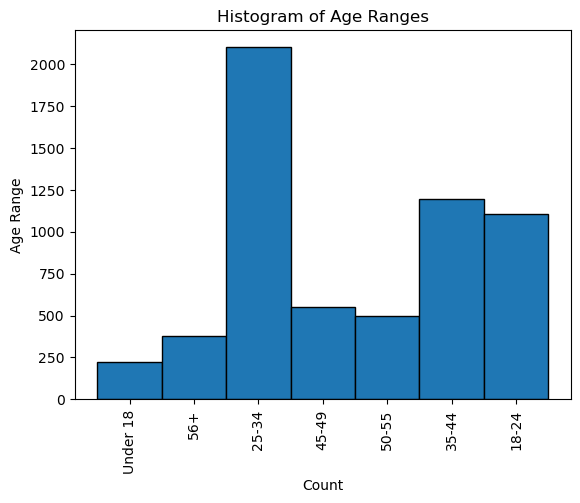

In [36]:
from collections import Counter
data = users.select("age").toPandas()["age"].astype(int).apply(lambda x: label_mapping[x]).tolist()
counter = Counter(data)

plt.bar(counter.keys(), counter.values(), edgecolor='black', width=1.0) 
plt.xlabel('Count')
plt.ylabel('Age Range')
plt.xticks(rotation=90)
plt.title('Histogram of Age Ranges')
plt.show()

Permuting the labels of the age into a cardinal order (1, 2, 3, 4, 5, 6, 7)

In [37]:
users.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- gender: integer (nullable = false)
 |-- age: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- zipcode: string (nullable = true)



In [38]:
label_mapping = {
    1: 1,
    18: 2,
    25: 3,
    35: 4,
    45: 5,
    50: 6,
    56: 7
}

age_udf = udf(lambda record: label_mapping[int(record)], IntegerType())
users = users.withColumn("age_cardinal", age_udf(users["age"]))
users = users.drop("age")

In [39]:
users.show(5)

+-------+------+----------+-------+------------+
|user_id|gender|occupation|zipcode|age_cardinal|
+-------+------+----------+-------+------------+
|      1|     0|        10|  48067|           1|
|      2|     1|        16|  70072|           7|
|      3|     1|        15|  55117|           3|
|      4|     1|         7|  02460|           5|
|      5|     1|        20|  55455|           3|
+-------+------+----------+-------+------------+
only showing top 5 rows



### 4.2.3. Occupation Distribution

In [40]:
label_mapping = {
    0: "other",
    1: "academic/educator", 
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer"
}

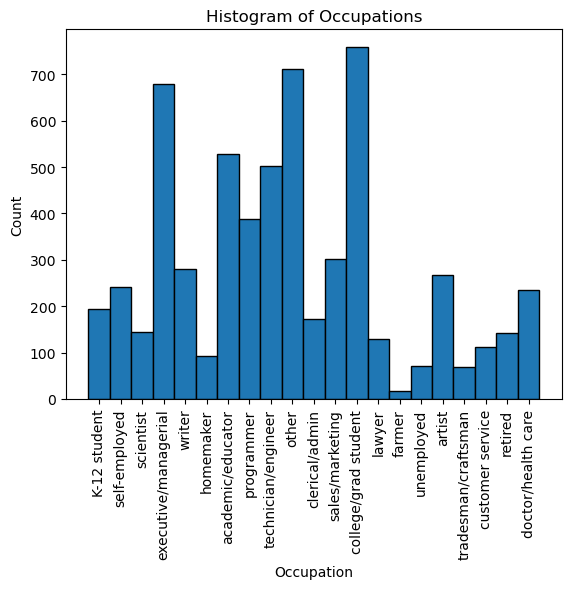

In [41]:
data = users.select("occupation").toPandas()["occupation"]
histogram_labels = data.unique().astype(int).tolist()
counts, bins, _ = plt.hist(data, edgecolor='black', bins = np.arange(len(histogram_labels)+1)-0.5)
tick_positions = plt.xticks()[0]
tick_labels = [histogram_labels[int(pos)] for pos in tick_positions]
new_tick_labels = [label_mapping[label] for label in tick_labels]
plt.xticks(tick_positions, new_tick_labels, rotation=90)
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.title('Histogram of Occupations')
plt.show()

## 4.3. Ratings Dataset

In [42]:
ratings.show(5)

+-------+--------+------+----------+
|user_id|movie_id|rating|time_stamp|
+-------+--------+------+----------+
|      1|    1193|     5| 978300760|
|      1|     661|     3| 978302109|
|      1|     914|     3| 978301968|
|      1|    3408|     4| 978300275|
|      1|    2355|     5| 978824291|
+-------+--------+------+----------+
only showing top 5 rows



In [43]:
ratings.groupBy("movie_id").count().sort("count", ascending=False).show(10)

+--------+-----+
|movie_id|count|
+--------+-----+
|    2858| 3428|
|     260| 2991|
|    1196| 2990|
|    1210| 2883|
|     480| 2672|
|    2028| 2653|
|     589| 2649|
|    2571| 2590|
|    1270| 2583|
|     593| 2578|
+--------+-----+
only showing top 10 rows



In [44]:
ratings.groupBy("user_id").count().sort("count", ascending=False).show(10)

+-------+-----+
|user_id|count|
+-------+-----+
|   4169| 2314|
|   1680| 1850|
|   4277| 1743|
|   1941| 1595|
|   1181| 1521|
|    889| 1518|
|   3618| 1344|
|   2063| 1323|
|   1150| 1302|
|   1015| 1286|
+-------+-----+
only showing top 10 rows



feature adjustments

In [45]:
for col in ratings.columns:
    ratings = ratings.withColumn(col, ratings[col].cast(IntegerType()))

In [46]:
ratings.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- movie_id: integer (nullable = true)
 |-- rating: integer (nullable = true)
 |-- time_stamp: integer (nullable = true)



# 5. Recommendation Modelling

In [47]:
(training, test) = ratings.randomSplit([0.8, 0.2])

In [48]:
training.show(5)

+-------+--------+------+----------+
|user_id|movie_id|rating|time_stamp|
+-------+--------+------+----------+
|      1|       1|     5| 978824268|
|      1|      48|     5| 978824351|
|      1|     150|     5| 978301777|
|      1|     260|     4| 978300760|
|      1|     527|     5| 978824195|
+-------+--------+------+----------+
only showing top 5 rows



In [49]:
test.show(5)

+-------+--------+------+----------+
|user_id|movie_id|rating|time_stamp|
+-------+--------+------+----------+
|      1|     531|     4| 978302149|
|      1|    1029|     5| 978302205|
|      1|    1097|     4| 978301953|
|      1|    1545|     4| 978824139|
|      1|    2692|     4| 978301570|
+-------+--------+------+----------+
only showing top 5 rows



## 5.1. User-Based Filtering

### 5.1.1. Colaborative Filtering via Matrix Factorization Algorithm (ALS)

#### 5.1.1.1. Training a base Model

In [50]:
als = ml.recommendation.ALS(maxIter=15, 
          regParam=0.1, 
          userCol="user_id", 
          itemCol="movie_id", 
          ratingCol="rating",
          coldStartStrategy="drop")

model = als.fit(training)

In [51]:
train_predictions = model.transform(training)
test_predictions = model.transform(test)

In [52]:
train_predictions.show(5)

+-------+--------+------+----------+----------+
|user_id|movie_id|rating|time_stamp|prediction|
+-------+--------+------+----------+----------+
|    148|       1|     5| 977335193| 4.2927213|
|    148|       2|     5| 979578366|  3.715332|
|    148|       7|     3| 977335047| 3.7130244|
|    148|      10|     4| 977333469| 3.9604435|
|    148|      11|     5| 977334939| 4.0270143|
+-------+--------+------+----------+----------+
only showing top 5 rows



In [53]:
test_predictions.show(5)

+-------+--------+------+----------+----------+
|user_id|movie_id|rating|time_stamp|prediction|
+-------+--------+------+----------+----------+
|    148|      23|     3| 979578872| 3.4221115|
|    148|     239|     4| 979578936| 3.4316158|
|    148|     253|     3| 977353145| 3.6423802|
|    148|     262|     4| 977353521|   3.83092|
|    148|     300|     2| 977352828| 3.5389957|
+-------+--------+------+----------+----------+
only showing top 5 rows



In [54]:
import pyspark.ml.evaluation as evaluation

evaluator = evaluation.RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

train_rmse = evaluator.evaluate(train_predictions)
test_rmse = evaluator.evaluate(test_predictions)

print(f"For NMF ALS method, RMSE for training = {train_rmse}, while for testing = {test_rmse}" )

For NMF ALS method, RMSE for training = 0.8130896044225708, while for testing = 0.8635873478913221


#### 5.1.1.2. Hyper-Parameter Optimization using GridSearch for Regularization & Ranking

In [56]:
results = {
    "regularization": [],
    "rank_dim": [],
    "train_rmse": [],
    "test_rmse": []
}

for regularization in [0.01, 0.1, 0.5, 1]:
    for rank_dim in range(10, 35, 5):
        als = ml.recommendation.ALS(maxIter=10,
          rank=rank_dim,
          regParam=regularization, 
          userCol="user_id", 
          itemCol="movie_id", 
          ratingCol="rating",
          coldStartStrategy="drop")

        model = als.fit(training)
        
        train_predictions = model.transform(training)
        test_predictions = model.transform(test)
        
        results["regularization"].append(regularization)
        results["rank_dim"].append(rank_dim)
        results["train_rmse"].append(evaluator.evaluate(train_predictions))
        results["test_rmse"].append(evaluator.evaluate(test_predictions))

In [57]:
pd.DataFrame(results)

,regularization,rank_dim,train_rmse,test_rmse
0,0.01,10,0.750058,0.890498
1,0.01,15,0.705436,0.916786
2,0.01,20,0.668074,0.942772
3,0.01,25,0.633875,0.960009
4,0.01,30,0.603676,0.975668
5,0.10,10,0.820085,0.869716
6,0.10,15,0.809352,0.867598
7,0.10,20,0.802960,0.867187
8,0.10,25,0.798382,0.866637
9,0.10,30,0.795921,0.866936


<b>Therefore it is noticed that the model fits the best when reg = 0.1 and rank of representation = 30. However Underfitting is noticed as 0.787 is significantly a relatively high RMSE</b>

### 5.1.2. Colaborative Filtering via User Similarity Algorithm (KNN)

#### 5.1.2.1. Preparing the users dataset 

In [58]:
for col in users.columns:
    users = users.withColumn(col, users[col].cast(IntegerType()))

In [60]:
users = users.na.fill(0)

In [59]:
users.show(5)

+-------+------+----------+-------+------------+
|user_id|gender|occupation|zipcode|age_cardinal|
+-------+------+----------+-------+------------+
|      1|     0|        10|  48067|           1|
|      2|     1|        16|  70072|           7|
|      3|     1|        15|  55117|           3|
|      4|     1|         7|   2460|           5|
|      5|     1|        20|  55455|           3|
+-------+------+----------+-------+------------+
only showing top 5 rows



**Encoding the Occupation via One Hot Encoding**

In [61]:
from pyspark.ml.feature import OneHotEncoder

encoder = OneHotEncoder(inputCol="occupation", dropLast=False, outputCol="encoded_occupation")
users = encoder.fit(users).transform(users)
users = users.drop("occupation")
users.show(5)

+-------+------+-------+------------+------------------+
|user_id|gender|zipcode|age_cardinal|encoded_occupation|
+-------+------+-------+------------+------------------+
|      1|     0|  48067|           1|   (21,[10],[1.0])|
|      2|     1|  70072|           7|   (21,[16],[1.0])|
|      3|     1|  55117|           3|   (21,[15],[1.0])|
|      4|     1|   2460|           5|    (21,[7],[1.0])|
|      5|     1|  55455|           3|   (21,[20],[1.0])|
+-------+------+-------+------------+------------------+
only showing top 5 rows



**Encoding the ZipCode via One Hot Encoding**

In [62]:
zipcode_udf = udf(lambda record: record // 10000, IntegerType())
users = users.withColumn("categorical_zipcode", zipcode_udf(users["zipcode"]))
#users = users.drop("zipcode")
users.show(5)

+-------+------+-------+------------+------------------+-------------------+
|user_id|gender|zipcode|age_cardinal|encoded_occupation|categorical_zipcode|
+-------+------+-------+------------+------------------+-------------------+
|      1|     0|  48067|           1|   (21,[10],[1.0])|                  4|
|      2|     1|  70072|           7|   (21,[16],[1.0])|                  7|
|      3|     1|  55117|           3|   (21,[15],[1.0])|                  5|
|      4|     1|   2460|           5|    (21,[7],[1.0])|                  0|
|      5|     1|  55455|           3|   (21,[20],[1.0])|                  5|
+-------+------+-------+------------+------------------+-------------------+
only showing top 5 rows



In [63]:
users = users.withColumn("categorical_zipcode", users["categorical_zipcode"].cast(IntegerType()))

In [64]:
encoder = OneHotEncoder(inputCol="categorical_zipcode", dropLast=False, outputCol="encoded_zipcode")
users = encoder.fit(users).transform(users)
users = users.drop("categorical_zipcode")
users.show(5)

+-------+------+-------+------------+------------------+-----------------+
|user_id|gender|zipcode|age_cardinal|encoded_occupation|  encoded_zipcode|
+-------+------+-------+------------+------------------+-----------------+
|      1|     0|  48067|           1|   (21,[10],[1.0])|(19313,[4],[1.0])|
|      2|     1|  70072|           7|   (21,[16],[1.0])|(19313,[7],[1.0])|
|      3|     1|  55117|           3|   (21,[15],[1.0])|(19313,[5],[1.0])|
|      4|     1|   2460|           5|    (21,[7],[1.0])|(19313,[0],[1.0])|
|      5|     1|  55455|           3|   (21,[20],[1.0])|(19313,[5],[1.0])|
+-------+------+-------+------------+------------------+-----------------+
only showing top 5 rows



movies.show(5)

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

indexer = StringIndexer(inputCol="genre", outputCol="genre_indexed")
indexed_df = indexer.fit(movies).transform(movies)

encoder = OneHotEncoder(inputCol="genre_indexed", dropLast=False, outputCol="encoded_genre")
pipeline = Pipeline(stages=[indexer, encoder])
pipeline_model = pipeline.fit(movies)
movies = pipeline_model.transform(movies)

movies.show()

import pyspark.sql.functions as F

aggregated_df = movies.groupby("movie_id").agg(F.sum("encoded_genre").alias("genre_sum"))

from pyspark.sql.functions import sum as sum_cols
